YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\BAYEE\AppData\Local\Temp\ipykernel_9628\1634479686.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm["SMA_50"] = df_lstm["Close"].rolling(window=50).mean()
C:\Users\BAYEE\AppData\Local\Temp\ipykernel_9628\1634479686.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm["Close_Scaled"] = scaler.fit_transform(df_lstm[["Close"]])
C:\Users\BAYEE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 0.0640
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0062
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0037
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0041
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0031
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0028
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0026
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0022
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0023
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0026
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0021
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0020
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0021
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0019
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0018
Epo

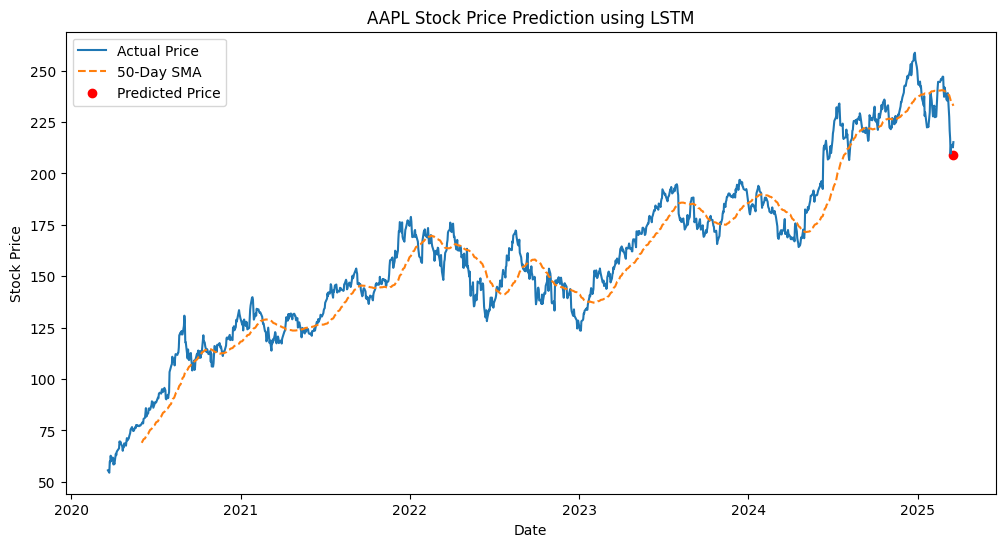

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to fetch stock data
def fetch_stock_data(ticker, period="5y"):
    stock_data = yf.download(ticker, period=period)
    if stock_data.empty:
        raise ValueError(f"No data found for ticker symbol: {ticker}")
    return stock_data

# User-defined parameters
ticker = "AAPL"  # Change to desired stock symbol
lookback = 60
epochs = 50
batch_size = 32

# Fetch data
stock_data = fetch_stock_data(ticker)
stock_data.reset_index(inplace=True)
df_lstm = stock_data[["Date", "Close"]]

# Compute a simple moving average (SMA)
df_lstm["SMA_50"] = df_lstm["Close"].rolling(window=50).mean()

# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm["Close_Scaled"] = scaler.fit_transform(df_lstm[["Close"]])

# Prepare the dataset for LSTM
X, y = [], []
for i in range(lookback, len(df_lstm)):
    X.append(df_lstm["Close_Scaled"].values[i - lookback:i])
    y.append(df_lstm["Close_Scaled"].values[i])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build and train the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

# Predict the next day's stock price
test_data = df_lstm["Close_Scaled"].values[-lookback:].reshape(1, lookback, 1)
predicted_price_scaled = model.predict(test_data)
predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))

print(f"Predicted Closing Price for {ticker}: {predicted_price[0][0]:.2f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_lstm["Date"], df_lstm["Close"], label="Actual Price")
plt.plot(df_lstm["Date"], df_lstm["SMA_50"], label="50-Day SMA", linestyle="dashed")
plt.scatter(df_lstm["Date"].iloc[-1], predicted_price, color='red', label="Predicted Price", marker='o')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title(f"{ticker} Stock Price Prediction using LSTM")
plt.show()
